In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

def write_table(df, the_name, caption=""):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write(df.style.to_latex(hrules=True, sparse_index=False, environment="longtable", position="!hbt", caption=caption, label="tbl:"+the_name))

In [2]:
df = pd.read_csv("shloka/mahabharata.csv")
df_localisation = pd.read_csv("shloka/mahabharata-localisation.csv")

In [3]:
df_localisation.position

0          1
1          5
2          9
3         11
4         13
          ..
809848     7
809849     9
809850    11
809851    12
809852    14
Name: position, Length: 809853, dtype: int64

In [4]:
df_localisation.groupby(["lengths", "position"])["word"].count()["LGGL"]

position
1     1020
2      332
3       52
5     7390
9     1516
10     325
Name: word, dtype: int64

<AxesSubplot:xlabel='position'>

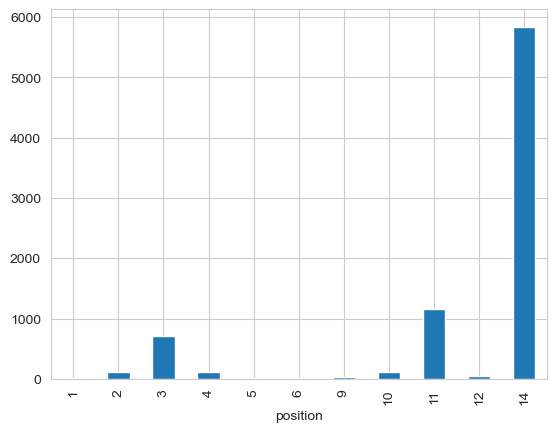

In [5]:
df_localisation.groupby(["lengths", "position"]).size()["GLL"].plot.bar()

In [6]:
df_localisation[df_localisation["lengths"] == "LGL"]

,parva,sub_parva,verse,sub_verse,word,lengths,position
97,1,1,10,c,bahUni,LGL,1
140,1,1,13,e,bhavanta,LGL,1
143,1,1,13,e,bravImi,LGL,9
596,1,1,55,c,jagAma,LGL,1
605,1,1,56,a,gateSu,LGL,9
...,...,...,...,...,...,...,...
809333,18,5,7,e,uvAca,LGL,2
809440,18,5,17,c,viveza,LGL,1
809596,18,5,30,c,nRpasya,LGL,13
809679,18,5,38,c,ihAsti,LGL,2


<AxesSubplot:>

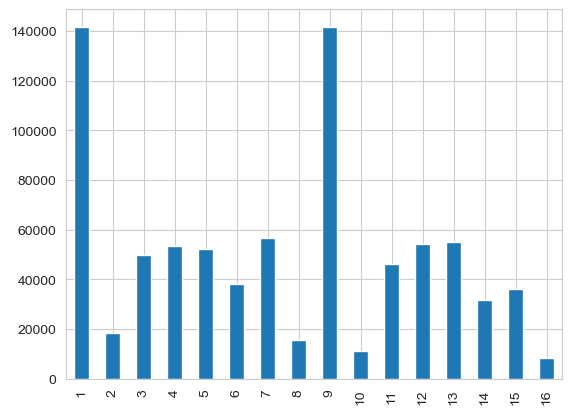

In [9]:
df_localisation["position"].value_counts().sort_index().plot.bar()